In [167]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import operator
from scipy.optimize import minimize
import math

In [168]:
def gen_dx_recursive(mu_real,sig_real,dt,N):
    N=np.int64(N)
    X = np.zeros((N))
    X[0]=0.5
    dW=np.sqrt(dt)*np.random.normal(0, 1, N)
    e = np.zeros((N))
    for i in range(1,N):
        b= sig_real*X[i-1]*(1-X[i-1])
        a= mu_real*(0.5 - X[i-1])
        X[i]= X[i-1]+ a*dt+ b*dW[i-1]
    return(X)

In [169]:
def liklihood(param,data, disc):
    L=0
    X=data
    N,dt=disc;
    N=np.int64(N)
    mu,sig =param;
    for i in range(1,N):
        b= sig*X[i-1]*(1-X[i-1])
        a= mu*(0.5 - X[i-1])
        L = L  - (X[i]-X[i-1]-a*dt )**2/(2*dt*b**2) -0.5*np.log(2*math.pi*b**2*dt)
    return(-1*L)

In [170]:
def gen_paths(mu_real,sig_real,dt,N,num_paths=1):
    L = np.zeros((num_paths,N))
    for i in range(0,num_paths):
        L[i]=gen_dx_recursive(mu_real,sig_real,dt,N)
    return(L)

In [171]:
def covergence_test(disc ,param_real, param_initial):
    
    N,dt=disc;
    mu_real,sig_real=param_real
    mu_initial,sig_initial=param_initial
    
    e=gen_dx_recursive(mu_real,sig_real,dt,N)
    
    args=(e,disc)
    x0=param_initial
    bnds = ((None, None), (1e-5, None))
    
    min_param=minimize(liklihood,x0,args,bounds=bnds);min_param
    #min_param=minimize(liklihood,x0,args,method='SLSQP',bounds=bnds,\
                   #tol=1e-24,options={  'ftol': 1e-24,  'eps': 1e-12});min_param
    error = np.divide ( abs(min_param.x - param_real),param_real )
    
    return(min_param.x, error)

In [172]:
#varying number of samples

def convergence_in_N(N_test,fix_dt,param_real_test,param_initial_test):

    err_fixeddt=np.zeros((len(N_test),2))
    result_fixeddt=np.zeros((len(N_test),2))

    for i in range(0,len(N_test)):
        disc_test=np.array([N_test[i],fix_dt])
        result_fixeddt[i,:],err_fixeddt[i,:]=covergence_test(disc_test,param_real_test,param_initial_test)
        
    return(result_fixeddt,err_fixeddt)

In [173]:
#varying number of paths

def convergence_in_L(N_test,fix_dt,param_real_test,param_initial_test,num_paths ):
    result_fixeddt= np.zeros(( num_paths ,len(N_test),2))
    err_fixeddt= np.zeros(( num_paths ,len(N_test),2))

    for i in range(0,num_paths):
        result_fixeddt[i,:,:],err_fixeddt[i,:,:]=convergence_in_N(N_test,fix_dt,param_real_test,param_initial_test)
    return(result_fixeddt, err_fixeddt)

In [174]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label='slope='+str(slope))

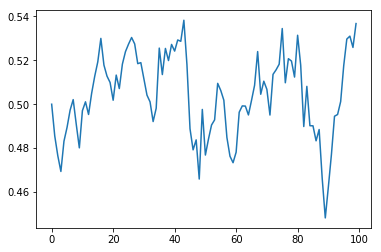

In [175]:
y=gen_dx_recursive(mu_real=0.1,sig_real=0.05,dt=1,N=100)
plt.plot(y)

In [183]:
#convergence for increasing number of paths and samples

N_test=np.array([2,10,100,1000]) #,100,500,1000,10000,50000

fix_dt=1
param_real_test=np.array([0.1,0.01])
param_initial_test= np.array([0.5,0.03])

num_paths_test=np.array([2,10,100,1000]) #,1000,10000


result_fixeddt_avg=np.zeros((len(num_paths_test),len(N_test),2))
err_fixeddt_avg=np.zeros((len(num_paths_test),len(N_test),2))

for i in range(0,len(num_paths_test)):
    result_fixeddt,_=convergence_in_L(N_test,fix_dt,param_real_test,param_initial_test,num_paths_test[i] )
    #obtain averaging estimator
    result_fixeddt_avg[i]=np.average(result_fixeddt, axis=0)
    #error estimates
    err_fixeddt_avg[i,:,0] = np.divide ( abs(result_fixeddt_avg[i,:,0] - param_real_test[0]), param_real_test[0] )
    err_fixeddt_avg[i,:,1]=np.divide ( abs(result_fixeddt_avg[i,:,1] - param_real_test[1]), param_real_test[1] )

In [184]:
result_fixeddt_avg

array([[[0.5       , 0.00710553],
        [0.19386921, 0.0068948 ],
        [0.13187257, 0.00841517],
        [0.11175433, 0.01012629]],

       [[0.5       , 0.0080254 ],
        [0.20396668, 0.00921145],
        [0.11743061, 0.01045879],
        [0.10909929, 0.0100069 ]],

       [[0.5       , 0.00816443],
        [0.19536127, 0.00953918],
        [0.11322972, 0.0099964 ],
        [0.10038548, 0.0100188 ]],

       [[0.5       , 0.0080809 ],
        [0.24672179, 0.00924654],
        [0.11715503, 0.00989319],
        [0.10155818, 0.00998629]]])

In [185]:
err_fixeddt_avg

array([[[4.00000000e+00, 2.89446673e-01],
        [9.38692102e-01, 3.10519859e-01],
        [3.18725658e-01, 1.58483498e-01],
        [1.17543286e-01, 1.26290853e-02]],

       [[4.00000000e+00, 1.97459618e-01],
        [1.03966683e+00, 7.88552015e-02],
        [1.74306128e-01, 4.58787410e-02],
        [9.09929334e-02, 6.89906709e-04]],

       [[4.00000000e+00, 1.83556958e-01],
        [9.53612656e-01, 4.60821900e-02],
        [1.32297151e-01, 3.59689418e-04],
        [3.85482468e-03, 1.88002440e-03]],

       [[4.00000000e+00, 1.91909865e-01],
        [1.46721786e+00, 7.53464416e-02],
        [1.71550290e-01, 1.06807412e-02],
        [1.55818393e-02, 1.37128105e-03]]])